<a href="https://colab.research.google.com/github/iabcshsh/codewars/blob/main/6_Spam_Detection_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Harnessing TensorFlow BERT Uncased: A Novel Approach to SMS Spam Detection

## Importing Libraries

In [ ]:
!pip install bert-tensorflow
!pip install --upgrade bert
!pip install tokenization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 5.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert: filename=bert-2.2.0-py3-none-any.whl size=3745 sha256=353bd92b67291e2108baacbe9ea7f2049a5f7da534fc701300bee14a1dbedc44
  Stored in directory: /root/.cache/pip/wheels/d0/97/c8/5775d57c323970511488d9b53ce66cf0ded394fe4b4f6e0afb
  Created wheel for erlastic: filename=erlastic-2.0.0-py3-none-any.whl size=6777 sha256=f60d4c83574f90a093550012244f5f582f71d240e07c7d625575bb03c043867a
  Stored in directory: /root/.cache/pip/wheels/f5/ca/b1/ce71c2e0e9e0df3786697d06d53574be03ef86cd4fb0e2cb99
Successfully built bert erlastic
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simp

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert
import re
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

## Loading the Dataset

In [ ]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
data = data.rename(columns={'v1': 'label', 'v2': 'message'})

## Data Preprocessing

In [ ]:
for i in range(0,5572):
    if data['label'][i]=="spam":
        data['label'][i]= 1
    else:
        data['label'][i]= 0

data.head(10)

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [ ]:
def dataoveriew(data, message):
    print(f'{message}:\n')
    print('Number of rows: ', data.shape[0])
    print("\nNumber of features:", data.shape[1])
    print("\nData Features:")
    print(data.columns.tolist())
    print("\nMissing values:")
    print(dict(data.isnull().sum()))
    print("\nUnique values:")
    print(dict(data.nunique()))

dataoveriew(data, 'Overview of the dataset')

Overview of the dataset:

Number of rows:  5572

Number of features: 2

Data Features:
['label', 'message']

Missing values:
{'label': 0, 'message': 0}

Unique values:
{'label': 2, 'message': 5169}


In [ ]:
for key,value in dict(data.isnull().sum()).items():
  if(value > 0):
    print(key, " ---> ", value)
  else:
    print(key, ' have No null values')

label  have No null values
message  have No null values


In [ ]:
data.duplicated().sum()

403

In [ ]:
data=data.drop_duplicates(keep='first')
data.duplicated().sum()

0

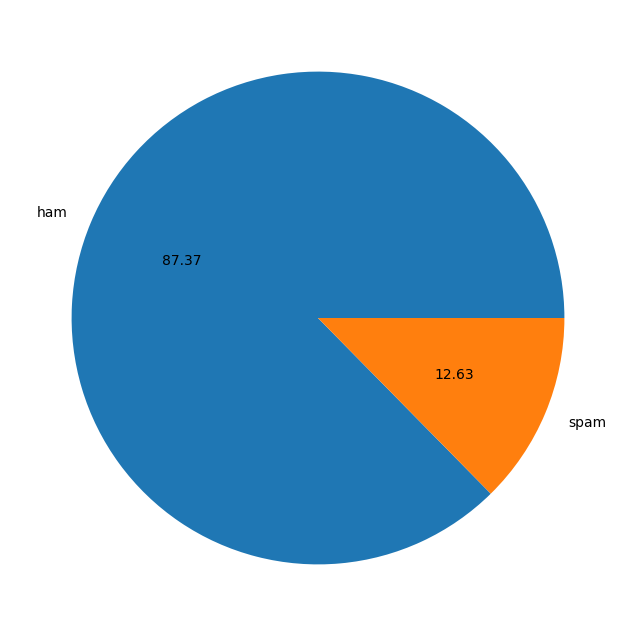

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 8))
plt.pie(data['label'].value_counts(),labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data['num_char']=data['message'].apply(len)
data.head()

,label,message,num_char
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [ ]:
data['num_word']=data['message'].apply(lambda x:len(nltk.word_tokenize(x)))
data.head()

,label,message,num_char,num_word
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [ ]:
data['num_sent']=data['message'].apply(lambda x:len(nltk.sent_tokenize(x)))
data.head()

,label,message,num_char,num_word,num_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
ps= PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Lowering and Stemming the whole text, removing the stopwords and removing the numbers
def transform_text(text):
    text=text.lower()
    text= nltk.word_tokenize(text)

    y=[]
    for i in text:
        if i.isalnum():
            y.append(i)

    text=y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text=y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

In [ ]:
data.head()

,label,message,num_char,num_word,num_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [ ]:
data['message'] = data['message'].apply(transform_text)
data.head()

,label,message,num_char,num_word,num_sent
0,0,go jurong point crazi avail bugi n great world...,111,24,2
1,0,ok lar joke wif u oni,29,8,2
2,1,free entri 2 wkli comp win fa cup final tkt 21...,155,37,2
3,0,u dun say earli hor u c alreadi say,49,13,1
4,0,nah think goe usf live around though,61,15,1


In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(df['text'],df['target'], stratify=df['target'])

## Splitting Data into Training and Testing Sets

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(data['message'],data['label'], test_size=0.2, random_state=42, stratify=data['label'])

In [ ]:
train_y = np.asarray(train_y).astype(np.int)
test_y = np.asarray(test_y).astype(np.int)

<ipython-input-26-8a0c6f188277>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_y = np.asarray(train_y).astype(np.int)
<ipython-input-26-8a0c6f188277>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1

In [ ]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 72.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

## Creating the Model

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(train_x, train_y, epochs=25)

Epoch 1/25
130/130 [==============================] - 61s 326ms/step - loss: 0.3421 - accuracy: 0.8716 - precision: 0.3043 - recall: 0.0134
Epoch 2/25
130/130 [==============================] - 45s 349ms/step - loss: 0.2505 - accuracy: 0.8912 - precision: 0.9091 - recall: 0.1533
Epoch 3/25
130/130 [==============================] - 45s 345ms/step - loss: 0.2119 - accuracy: 0.9156 - precision: 0.9100 - recall: 0.3678
Epoch 4/25
130/130 [==============================] - 45s 346ms/step - loss: 0.1880 - accuracy: 0.9287 - precision: 0.9011 - recall: 0.4885
Epoch 5/25
130/130 [==============================] - 45s 348ms/step - loss: 0.1739 - accuracy: 0.9357 - precision: 0.9000 - recall: 0.5517
Epoch 6/25
130/130 [==============================] - 45s 345ms/step - loss: 0.1654 - accuracy: 0.9434 - precision: 0.9162 - recall: 0.6073
Epoch 7/25
130/130 [==============================] - 45s 346ms/step - loss: 0.1566 - accuracy: 0.9499 - precision: 0.9112 - recall: 0.6686
Epoch 8/25
130/130 [

In [ ]:
model.evaluate(test_x, test_y)

33/33 [==============================] - 14s 379ms/step - loss: 0.1231 - accuracy: 0.9623 - precision: 0.8710 - recall: 0.8244


[0.12314076721668243,
 0.9622824192047119,
 0.8709677457809448,
 0.8244274854660034]

In [ ]:
y_predicted = model.predict(test_x)
y_predicted = y_predicted.flatten()

33/33 [==============================] - 15s 379ms/step


In [ ]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(test_y, y_predicted)
cm

array([[887,  16],
       [ 23, 108]])

Text(95.72222222222221, 0.5, 'Truth')

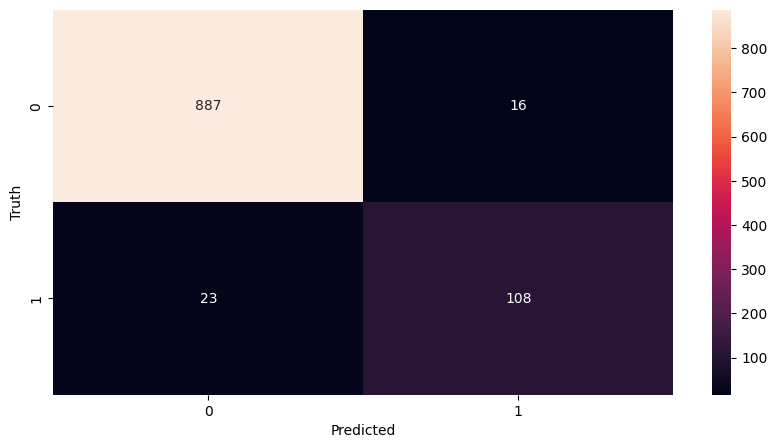

In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(test_y, y_predicted))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       903
           1       0.87      0.82      0.85       131

    accuracy                           0.96      1034
   macro avg       0.92      0.90      0.91      1034
weighted avg       0.96      0.96      0.96      1034

